# Lab 4
by Bjørn Christian Weinbach

## Problem 1

### Imports

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix
import seaborn as sns
sys.path.append("..") # Adds higher directory to python modules path.
import pdffuns

### Read data

In [2]:
pfile = 'lab4.p'
with open(pfile, "rb") as fp:
    Test, Train = pickle.load(fp)

In [3]:
Train_omega1, Train_omega2, Test_omega1, Test_omega2 = Train[0], Train[1], Test[0], Test[1]

## Plot training data

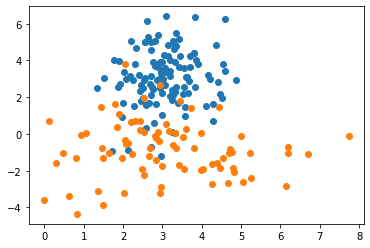

In [4]:
plt.scatter(Train_omega1[0], Train_omega1[1])
plt.scatter(Train_omega2[0], Train_omega2[1])

## Plot test data

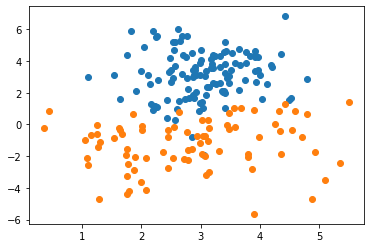

In [5]:
plt.scatter(Test_omega1[0], Test_omega1[1])
plt.scatter(Test_omega2[0], Test_omega2[1])

## Construct dataframe

### training dataset

In [6]:
train = pd.DataFrame({'x1': list(Train_omega1[0]), 'x2': list(Train_omega1[1]), 'class': list(np.zeros(len(Train_omega1[1])))})
train = train.append(pd.DataFrame({'x1': list(Train_omega2[0]), 'x2': list(Train_omega2[1]), 'class': list(np.ones(len(Train_omega2[0])))}))
train = train.reset_index(drop=True)

### test dataset

In [7]:
test = pd.DataFrame({'x1': list(Test_omega1[0]), 'x2': list(Test_omega1[1]), 'class': list(np.zeros(len(Test_omega1[1])))})
test = test.append(pd.DataFrame({'x1': list(Test_omega2[0]), 'x2': list(Test_omega2[1]), 'class': list(np.ones(len(Test_omega2[1])))}))
test = test.reset_index(drop=True)

## Classify test-data

Using classify method in pdffuns. It returns the classifications and function values.
This method works for any dimension.

In [8]:
classpred_test, funcval_test = pdffuns.classifyML(train, test)

## Reclassify train-data

In [9]:
classpred_train, funcval_train = pdffuns.classifyML(train, train)

## Reclassification confusion matrix

In [10]:
reclassification_cm = confusion_matrix(np.array(train['class']), classpred_train)

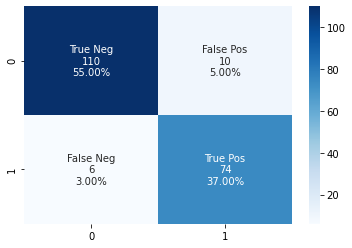

In [11]:
def confusionMatrix(cfm):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cfm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cfm.flatten()/np.sum(cfm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cfm, annot=labels, fmt='', cmap='Blues')

confusionMatrix(reclassification_cm)

## Test confusion matrix

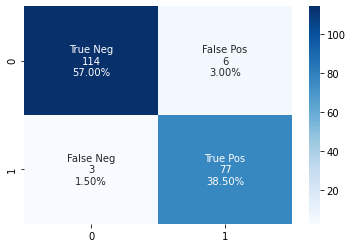

In [12]:
test_cm = confusion_matrix(np.array(test['class']), classpred_test)
confusionMatrix(test_cm)

In [13]:
def recall(confusionMatrix, correct):
    return confusionMatrix[correct, correct] / sum(confusionMatrix[correct, :])

def precision(confusionMatrix, correct):
    return confusionMatrix[correct, correct] / sum(confusionMatrix[:, correct])

def accuracy(confusionMatrix):
    return (confusionMatrix[0, 0] + confusionMatrix[1, 1]) / sum(confusionMatrix.flatten())

## Calculate metrics for reclassification

In [14]:
def metrics(confusionMatrix):
    print("Error: " + str(1 - accuracy(confusionMatrix)))
    print("P(correct|0) " + str(recall(confusionMatrix, 0)))
    print("P(correct|1) " + str(recall(confusionMatrix, 1)))

metrics(reclassification_cm)

Error: 0.07999999999999996
P(correct|0) 0.9166666666666666
P(correct|1) 0.925


## Calculate metrics for test

In [15]:
metrics(test_cm)

Error: 0.04500000000000004
P(correct|0) 0.95
P(correct|1) 0.9625


## Parzen-classifier with $\Delta = 0.5$ and $h_1=0.1$

My implementation evaluates the density for a grid of points from the minimum to maximum values of feature 1 and 2. 
This classifier becomes increasingly computationally demanding, especially if the range is large and $h_1$ is small since this forces us to decrease $\Delta$ (step size) in the computation points.

## Reclassification

In [16]:
parzen_classpred_train = pdffuns.classifyParzen(train, train, window=0.1, delta=0.1)

## Reclassification confusion matrix

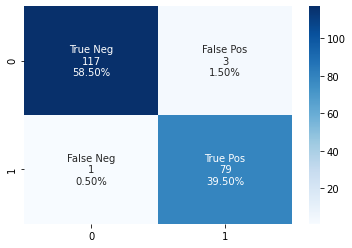

In [17]:
parzen_train_cm = confusion_matrix(np.array(train['class']), parzen_classpred_train)
confusionMatrix(parzen_train_cm)

In [18]:
metrics(parzen_train_cm)

Error: 0.020000000000000018
P(correct|0) 0.975
P(correct|1) 0.9875


## Test

In [19]:
parzen_classpred_test = pdffuns.classifyParzen(train, test, window=0.1, delta=0.1)

## Test confusion matrix

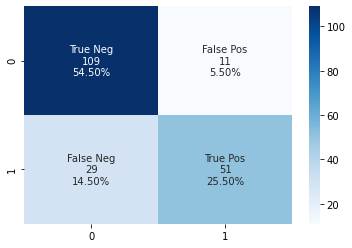

In [20]:
parzen_test_cm = confusion_matrix(np.array(test['class']), parzen_classpred_test)
confusionMatrix(parzen_test_cm)

In [21]:
metrics(parzen_test_cm)

Error: 0.19999999999999996
P(correct|0) 0.9083333333333333
P(correct|1) 0.6375


In [22]:
np.array(train.drop('class', axis=1).T)[:, 0]

array([2.57377388, 1.59511158])